# Comp 549 - Covid Fake News Detection (Team Free Spirit)

## 1. Loading and Exploring the Dataset.

### 1.1 Download Packages

In [1]:
# Download packages
!pip install livelossplot --quiet
!pip -q install transformers

### 1.2 Data Preprocessing

In [3]:
import pandas as pd

def ReadCSV(include_date=False):
    # Sperate the text and the label
    df = pd.read_csv('final.csv')
    texts = list()
    labels = list()

    for _, row in df.iterrows():
        if include_date:
            texts.append(f"{row[0][5:]}, {row[1]}")
        else:
            texts.append(row[1])
        labels.append(row[2])

    return texts, labels


texts, labels = ReadCSV(include_date=False)
print(f"Size of the dataset: {len(labels)}")

# Calculate the maximum text length
max_text_len = 0
for text in texts:
    if len(text) > max_text_len:
        max_text_len = len(text)

print(f"Maximum Text Length: {max_text_len}")

Size of the dataset: 6653
Maximum Text Length: 504


### 1.3 Main Class Definition



In [4]:
import torch
import pandas as pd
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split


class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, data_type='val'):
        # This will download the pretrained BertTokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        if data_type == 'train':
            # Split train and validation dataset and get train
            # train_test_split() => return (train_x, test_x, train_y, test_y)
            self.text, _, self.label, _ = train_test_split(texts, labels, test_size=0.2, random_state=42)
        elif data_type:
            # Split train and validation dataset and get validate
            _, self.text, _, self.label = train_test_split(texts, labels, test_size=0.2, random_state=42)

        # Pre-tokenizing all sentences
        print('Tokenizing...', end = '')
        self.tokenized_plots = list()
        for i in range(0, len(self.text)):
            text = self.text[i]
            # Method to generally tokenize it in projects:
            #
            # [Parameters]
            #
            # truncation => as BERT can only accept/take as input only 512 tokens at a time, we must specify the truncation parameter to True
            # add_special_tokens => is just for BERT to add tokens like the start, end, [SEP], and [CLS] tokens
            # return_tensors=“pt” => is just for the tokenizer to return PyTorch tensors. If you don’t want this to happen(maybe you want it to return a list), then you can remove the parameter and it will return lists
            # return_attention_mask => The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them.
            encoded_text = self.tokenizer.encode_plus(
                text, add_special_tokens = True, truncation = True, 
                max_length = 512, padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt')

            self.tokenized_plots.append(encoded_text)
        print(' finished')
            
    def __getitem__(self, index: int):
        # text => tensor([[ ... ]]) contains text ids in the tokenizers
        text = self.tokenized_plots[index]['input_ids'][0]
        text_mask = self.tokenized_plots[index]['attention_mask'][0]

        # Encode labels in a binary vector.
        #label_vector = torch.zeros(2)
        # Expand the dimension of label
        # => initially: label = 0 or 1
        # => now: label_vector = [1, 0] if label == 0, [0, 1] if label == 1
        #label_vector[self.label[index]] = 1
        label_vector = self.label[index]

        return text, text_mask, label_vector

    def get_data(self, index: int):
        text, label = self.data[index]
        return text, label

    def __len__(self):
        return len(self.text)


train_data = FakeNewsDataset(texts, labels, data_type='train')
print(f"Training size: {len(train_data)} samples\n")

val_data = FakeNewsDataset(texts, labels, data_type='val')
print(f"Validation size: {len(val_data)} samples")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizing... finished
Training size: 5322 samples

Tokenizing... finished
Validation size: 1331 samples


## 2. Train on BERT Model

### 2.1 Setting up Data Loaders

In [5]:
# Batch size is a liming factor on constrained resources.
# only GPUs with a large memory can hold large batches.
batch_size = 10

# If you load your samples in the Dataset on CPU and would like to push it during training to the GPU, you can speed up the host to device transfer by enabling pin_memory.
# This lets your DataLoader allocate the samples in page-locked memory, which speeds-up the transfer.
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size = batch_size,
                                           shuffle = True,
                                           pin_memory = True,
                                           num_workers = 2)

val_loader = torch.utils.data.DataLoader(val_data,
                                         batch_size = batch_size,
                                         shuffle = False)

### 2.2 Testing what a sample batch looks like.

In [ ]:
# iter() => convert list to iterator
# next() => the next element is the first element, then the second, then the third, ...
(text, text_mask, label) = next(iter(val_loader))

print(text.shape, text_mask.shape, label.shape)

torch.Size([10, 512]) torch.Size([10, 512]) torch.Size([10])


### 2.3. Loading the predefined BERT Transformer Model

Here we initialize the pretrained BERT model from the huggingface transformers library. They have several slightly different versions of it that are slightly modified for different tasks so you don't need to manually modify it (e.g. replacing last layer with something else) for your particular task. Do not be surprised if Google Colab keeps crashing. This is a very heavy model so I would recommend only running this cell once. Or if you have to run it twice, you might have to restart the runtime.

In [ ]:
from transformers import BertForSequenceClassification


# Loading BERT pre-trained classifier
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
    num_labels = 1, output_attentions = False, 
    output_hidden_states = False)

# Let's run a quick test on this model on the CPU.
output = model(text, text_mask)
print(f"\n{output.logits.shape}")

# Tell pytorch to run this model on the GPU.
model.cuda();

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


torch.Size([10, 1])


### 2.4. Training Loop for finetuning this BERT Model

In [ ]:
from transformers import get_linear_schedule_with_warmup
from livelossplot import PlotLosses
import torch.nn as nn

num_epochs = 2

# Following recommendations from the BERT paper and also this
# blog post https://mccormickml.com/2019/07/22/BERT-fine-tuning/
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-6, eps = 1e-8)

# Total number of training steps is [number of batches] * [number of epochs]. 
# (Note that this is not the same as the number of training samples)
total_steps = len(train_loader) * num_epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Binary Cross-Entroy Loss (BCE Loss).
# Please see documentation here:
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

# This loss combines a Sigmoid layer and the BCELoss in one single class
cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

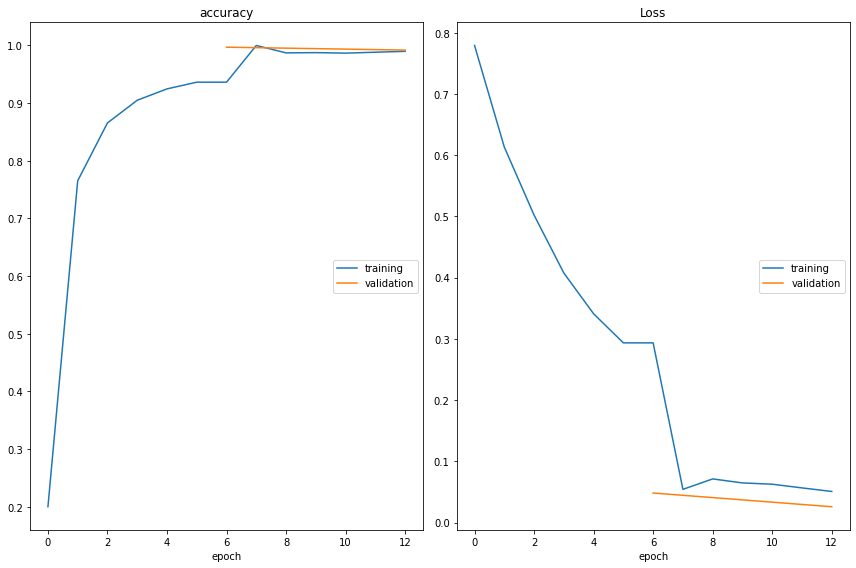

accuracy
	training         	 (min:    0.200, max:    1.000, cur:    0.990)
	validation       	 (min:    0.992, max:    0.997, cur:    0.992)
Loss
	training         	 (min:    0.051, max:    0.779, cur:    0.051)
	validation       	 (min:    0.026, max:    0.048, cur:    0.026)


In [ ]:
def batch_accuracy(predicted, labels):
    # Why sigmoid instead of softmax?
    # => The sigmoid function is used for the two-class logistic regression
    # => The softmax function is used for the multiclass logistic regression
    
    vals = predicted.data.sigmoid()
    pred_vals = vals > 0.5 # Anything with sigmoid > 0.5 is 1.

    #print(f"Prediction Value: {pred_vals}")
    #print(f"Labels: {labels}")

    return (pred_vals == labels).sum(dim = 1)


# Training Loop.
best_accuracy = 0
liveloss = PlotLosses()
current_step = 0
for epoch in range(0, num_epochs):
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    logs = {}
    model.train()
    for (batch_id, (texts, text_masks, labels)) in enumerate(train_loader):
        # Move to GPU.
        texts = texts.cuda()
        text_masks = text_masks.cuda()
        labels = labels[:, None]
        labels = labels.cuda()

        # Compute predictions.
        # Returns:
        # loss => Language modeling loss (for next-token prediction)
        # logits => Classification (or regression if config.num_labels==1) scores (before SoftMax)
        predicted = model(texts, text_masks)

        # Compute loss.
        loss = cost_function(predicted.logits, labels.float())

        # Compute cumulative loss and accuracy.
        # Returns the value of this tensor as a standard Python number. This only works for tensors with one element.
        cumulative_loss += loss.data.sum().item()

        cumulative_accuracy += batch_accuracy(predicted.logits, labels).sum().item()
        num_samples += texts.size(0)

        # Backpropagation and SGD update step.
        model.zero_grad()
        loss.mean().backward()
        optimizer.step()
        
        if batch_id % 100 == 0:
            logs['loss'] = cumulative_loss / num_samples
            logs['accuracy'] = cumulative_accuracy / num_samples
            liveloss.update(logs)
            liveloss.send()
            current_step += 1
    
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for (batch_id, (texts, text_masks, labels)) in enumerate(val_loader):
            # Move to GPU.
            texts = texts.cuda()
            text_masks = text_masks.cuda()
            labels = labels[:, None]
            labels = labels.cuda()

            # Compute predictions.
            predicted = model(texts, text_masks)

            # Compute loss.
            loss = cost_function(predicted.logits, labels.float())

            # Compute cumulative loss and top-5 accuracy.
            cumulative_loss += loss.data.sum().item()
            cumulative_accuracy += batch_accuracy(predicted.logits, labels).sum().item()
            num_samples += texts.size(0)

            if (1 + batch_id) % 100 == 0:
                logs['val_loss'] = cumulative_loss / num_samples
                logs['val_accuracy'] = cumulative_accuracy / num_samples    
                liveloss.update(logs, current_step)
                liveloss.send()

    # Advance scheduler.
    if scheduler != -1:
        scheduler.step()

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth') 

## 3. Validation

### 3.1 Load the pre-trained model

In [7]:
!pip -q install transformers

import torch
from transformers import BertForSequenceClassification


# Loading BERT pre-trained classifier
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
    num_labels = 1, output_attentions = False, 
    output_hidden_states = False)

# Tell pytorch to run this model on the GPU.
model.cuda()


# Load our pretrained model
model.load_state_dict(torch.load('best_model_so_far.pth'))
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### 3.2 Find out misclassified texts and labels

In [8]:
import numpy as np


batch_size = 10
raw_texts, raw_labels = ReadCSV(include_date=False)

val_data = FakeNewsDataset(raw_texts, raw_labels, data_type='val')
print(f"Validation size: {len(val_data)} samples\n")

val_loader = torch.utils.data.DataLoader(val_data,
                                         batch_size = batch_size,
                                         shuffle = False)


def validate_data(predicted_val, label, val_num):
    # Why sigmoid instead of softmax?
    # => The sigmoid function is used for the two-class logistic regression
    # => The softmax function is used for the multiclass logistic regression
    
    val = predicted_val.sigmoid()
    pred_label = val > 0.5 # Anything with sigmoid > 0.5 is 1.

    true_predicted = True
    if pred_label != label:
        true_predicted = False
        # print(val_num)
        # print(pred_label.item())
        # print(bool(label.item()))

    return pred_label.item(), bool(label.item()), true_predicted


def find_incorrect_data(val_loader):
    incorrect_samples = list()
    predictions = list()
    actual_labels = list()

    with torch.no_grad():
        for (batch_id, (texts, text_masks, labels)) in enumerate(val_loader):
            # Move to GPU.
            texts = texts.cuda()
            text_masks = text_masks.cuda()
            labels = labels[:, None]
            labels = labels.cuda()

            # Compute predictions.
            predicted = model(texts, text_masks)
            
            for i in range(len(predicted.logits.data)):
                val_num = batch_id * batch_size + i
                prediction, label, true_predicted = validate_data(predicted.logits.data[i], labels[i], val_num)

                predictions.append(prediction)
                actual_labels.append(label)

                if not true_predicted:
                    incorrect_samples.append(val_num)
                
    return predictions, actual_labels, incorrect_samples


predictions, actual_labels, incorrect_samples = find_incorrect_data(val_loader)

Tokenizing... finished
Validation size: 1331 samples



In [9]:
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support


# Specify label "True" is the first element
score = precision_recall_fscore_support(actual_labels, predictions, labels=[True, False], average='binary')

print(f"Confusion Matrix:\n{confusion_matrix(actual_labels, predictions, labels=[True, False])}\n")
print(f"Precision: {score[0]}")
print(f"Recall: {score[1]}")
print(f"F1-Score: {f1_score(actual_labels, predictions, labels=[True, False])}")

Confusion Matrix:
[[619   4]
 [  1 707]]

Precision: 0.9983870967741936
Recall: 0.9935794542536116
F1-Score: 0.99597747385358


In [10]:
val_texts = val_data.text
val_labels = val_data.label

for val_num in incorrect_samples:
    #print(val_num)
    print(f"Text: {val_texts[val_num]}")
    print(f"Prediction: {not bool(val_labels[val_num])}")
    print(f"Actual Label: {bool(val_labels[val_num])}\n\n")

Text: UK regulator provisionally clear Amazon’s investment in Deliveroo.
Prediction: False
Actual Label: True


Text: How should I clean and store my face mask?
Prediction: False
Actual Label: True


Text:  There is science behind Indian Prime minister Modi's 5 p.m. clapping initiative
Prediction: True
Actual Label: False


Text: Trump administration signs up new company to make COVID-19 drugs in
Prediction: False
Actual Label: True


Text: He smiled to comfort his COVID-19 patient - then he realized his mask was leaking
Prediction: False
Actual Label: True




## 4. Testing

### 4.1 Load the pre-trained model

In [11]:
!pip -q install transformers

import torch
from transformers import BertForSequenceClassification


# Loading BERT pre-trained classifier
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
    num_labels = 1, output_attentions = False, 
    output_hidden_states = False)

# Tell pytorch to run this model on the GPU.
model.cuda();


# Load our pretrained model
model.load_state_dict(torch.load('best_model_so_far.pth'))
model.eval();

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [12]:
from transformers import BertTokenizer


def test_tokenizer(title):
    # This will download the pretrained BertTokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Tokenizing the input sentence
    print('Tokenizing the test statement...', end = '')
    tokenized_plots = list()

    # Method to generally tokenize it in projects:
    #
    # [Parameters]
    #
    # truncation => as BERT can only accept/take as input only 512 tokens at a time, we must specify the truncation parameter to True
    # add_special_tokens => is just for BERT to add tokens like the start, end, [SEP], and [CLS] tokens
    # return_tensors=“pt” => is just for the tokenizer to return PyTorch tensors. If you don’t want this to happen(maybe you want it to return a list), then you can remove the parameter and it will return lists
    # return_attention_mask => The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them.
    encoded_text = tokenizer.encode_plus(
                    title,
                    add_special_tokens = True,
                    truncation = True,
                    max_length = 512,
                    padding = 'max_length',
                    return_attention_mask = True,
                    return_tensors = 'pt'
                )
    print(' finished\n')

    text = encoded_text['input_ids'][0]
    text_mask = encoded_text['attention_mask'][0]

    return text, text_mask


input_title = "The news team simulates deaths from COVID-19 in order to say there are more people dying than really is"
text, text_mask = test_tokenizer(input_title)

# Move to GPU.
text = text.cuda()
text_mask = text_mask.cuda()

# Compute the prediction
predicted_val = model(text.unsqueeze(0), text_mask.unsqueeze(0))

# Anything with sigmoid > 0.5 is 1
realiable_val = predicted_val.logits.data.sigmoid().item()

prediction = (realiable_val > 0.5)
print(f"Input Title: {input_title}")

if prediction == True:
    print(f"Prediction: {prediction} News")
elif prediction == False:
    print(f"Prediction: Fake News")


# Show our prediction confidence
if realiable_val <= 0.5:
    print("Confidence: {:.2f}%".format((0.5 - realiable_val) * 100 / 0.5))
else:
    print("Confidence: {:.2f}%".format(-(0.5 - realiable_val) * 100 / 0.5))

Tokenizing the test statement... finished

Input Title: The news team simulates deaths from COVID-19 in order to say there are more people dying than really is
Prediction: Fake News
Confidence: 97.23%
